In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 22 10:44:32 2025

@author: yatangli
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

In [3]:
fig_width = 8
fig_height = 8

def pca_svd(X,centralize=True):
    """
    SVD approach for principal components analysis
    X: n*p, n is the number of samples, p is the number of variables
    PV: principal axis 
    PC: principal components
    lambda: variance explained"""
    [n, p] = np.shape(X)                
    # centralize X
    X_0 = np.zeros((n,p))
    if centralize:
        for i in range(p):
            X_0[:,i] =  X[:,i]-np.mean(X[:,i])
    else:
        X_0 = X
    [U,S,V] = np.linalg.svd(X_0)
    lamda = np.square(S)/(n-1)
    lamda = lamda/np.sum(lamda)
    PV = V.T
    idx_neg = np.mean(PV,axis=0)<0
    PV[:,idx_neg] = -PV[:,idx_neg]
    PC = X_0@PV #principal components
    return PV, lamda, PC


def pca_eign(X,centralize=True):
    """
    eigenvector approach for principal components analysis
    X: n*p, n is the number of samples, p is the number of variables
    PV: principal axis 
    PC: principal components
    lambda: variance explained"""
    [n, p] = np.shape(X)                
    X_0 = X - np.mean(X, axis=0)
    if centralize:
        X_0 = X - np.mean(X, axis=0)
    else:
        X_0 = X
    C = X.T@X_0/(n-1) # covariance matrix: p*p
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    

    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    idx_neg = np.mean(eigenvectors,axis=0)<0
    eigenvectors[:,idx_neg] = -eigenvectors[:,idx_neg]

    lamda = eigenvalues/np.sum(eigenvalues)
    # Step 6: Project data onto principal components
    PC = X_0 @ eigenvectors

    return eigenvectors, lamda, PC

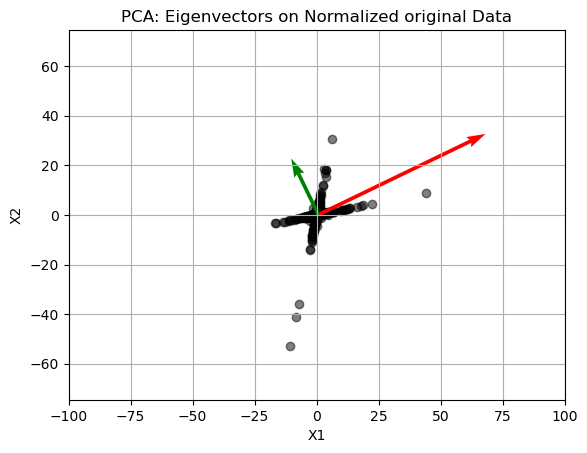

In [4]:
# Generate synthetic 2D data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
# S[:, 0] *= 5.0

# Mix data
A = np.array([[1,5], [5, 1]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

# pv,s,pc = pca_svd(X)
pv,s,pc = pca_eign(X)
X_norm = X/np.std(X)
X_mean = np.mean(X, axis=0)
plt.figure()
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.5, label='Normalized original Data',color='black')
for i in range(2):
    vec = pv[:, i]
    plt.quiver(*X_mean, *vec, scale=1/s[i]*2,angles='uv',
               color='r' if i == 0 else 'g', label=f'PC{i+1}')
plt.axis('equal')    
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("PCA: Eigenvectors on Normalized original Data")
# plt.legend()
plt.grid(True)
plt.show()

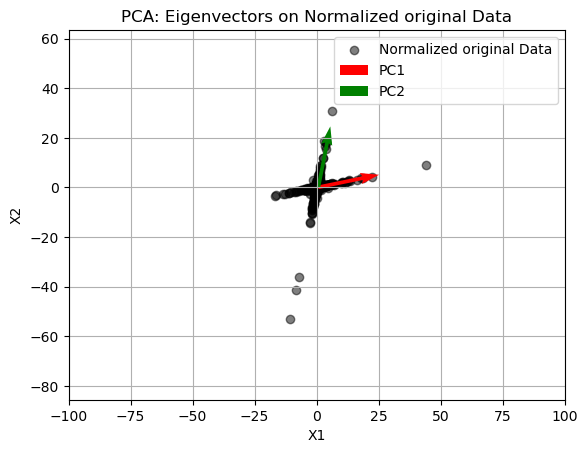

In [ ]:
def normalize_columns_l2(X):
    # Compute squared sum (L2 norm squared) for each column
    
    idx_neg = np.mean(X,axis=0)<0
    X[:,idx_neg] = -X[:,idx_neg]
    
    col_squared_sums = np.sum(X**2, axis=0)

    # Avoid divide-by-zero
    col_squared_sums[col_squared_sums == 0] = 1.0

    # Normalize each column
    X_normalized = X / np.sqrt(col_squared_sums)

    return X_normalized


ica = FastICA(random_state=rng, whiten="arbitrary-variance")
ic = ica.fit(X).transform(X)  # Estimate the sources
iv = normalize_columns_l2(ica.mixing_)

plt.figure()
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.5, label='Normalized original Data',color='black')
for i in range(2):
    vec = iv[:, i]
    plt.quiver(*X_mean, *vec, scale=8, angles='uv',
               color='r' if i == 0 else 'g', label=f'PC{i+1}')
plt.axis('equal')    
plt.xlim(-100,100)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("PCA: Eigenvectors on Normalized original Data")
# plt.legend()
plt.grid(True)
plt.show()

In [23]:
def var_explained(X, PV, PC):    
    # Total variance in original data
    total_variance = np.sum(np.var(X, axis=0))
    
    # Variance explained per component
    explained_variance = []
    
    for i in range(S.shape[1]):
        # Reconstruct using only the i-th component
        S_i = np.zeros_like(S)
        S_i[:, i] = PC[:, i]
        X_i = S_i @ PV.T
    
        # Compute variance of this component's contribution
        var_i = np.sum(np.var(X_i, axis=0))
        explained_variance.append(var_i)
    
    explained_variance = np.array(explained_variance)
    explained_ratio = explained_variance / total_variance
    
    # Display variance explained per component
    for i, ratio in enumerate(explained_ratio):
        print(f"Component {i+1}: {ratio:.4f} of total variance")
    return explained_ratio

In [ ]:
explained_ratio = var_explained(X, pv, pc)
explained_ratio = var_explained(X, ica.mixing_, ic)

Component 1: 0.7484 of total variance
Component 2: 0.2516 of total variance
Component 1: 0.6692 of total variance
Component 2: 0.3308 of total variance
